<a href="https://colab.research.google.com/github/choiitea/Choi_DSPN_S24/blob/main/Exercise13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 13:  Resampling methods

This homework assignment is designed to give you practice with bootstrapping and permutation tests.

You will need to download the **unrestricted_trimmed_1_7_2020_10_50_44.csv** file from the *Homework/hcp_data* folder in the class GitHub repository.

This data is a portion of the [Human Connectome Project database](http://www.humanconnectomeproject.org/). It provides measures of cognitive tasks and brain morphology measuresments from 1206 participants. The full description of each variable is provided in the **HCP_S1200_DataDictionary_April_20_2018.csv** file in the *Homework/hcp_data* folder in the class GitHub repository.

---
## 1. Loading & Visualizing the Data (1 point)

Use the `setwd` and `read.csv` functions to load data from the **unrestricted_trimmed_1_7_2020_10_50_44.csv** file.

(a) Using the tidyverse tools, make a new dataframe `d1` that only inclues the subject ID (`Subject`), gender (`Gender`, self reported at time of data collection), Flanker Task performance (`Flanker_Unadj`), total intracranial volume (`FS_IntraCranial_Vol`), total white matter volume (`FS_Tot_WM_Vol`), and total grey matter volume (`FS_Total_GM_Vol`) variables and remove all _na_ values.

Use the `head` function to look at the first few rows of each data frame.

In [21]:
# WRITE YOUR CODE HERE
library(tidyverse)

data <- read.csv("unrestricted_trimmed_1_7_2020_10_50_44.csv")
d1 <- data %>%
  select(Subject, Gender, Flanker_Unadj, FS_IntraCranial_Vol, FS_Tot_WM_Vol, FS_Total_GM_Vol) %>%
  drop_na()

head(d1)

,Subject,Gender,Flanker_Unadj,FS_IntraCranial_Vol,FS_Tot_WM_Vol,FS_Total_GM_Vol
,<int>,<chr>,<dbl>,<dbl>,<int>,<int>
1,100206,M,130.42,1864518,543134,807245
2,100307,F,112.56,1512540,407292,664124
3,100408,M,121.18,1684117,500417,726206
4,100610,M,126.53,1816044,512946,762308
5,101006,F,101.85,1437868,429449,579632
6,101107,M,107.04,1512727,416995,665024


(b) Plot grey matter volume (x axis) against intracranial volume (y axis) and Gender (point color).

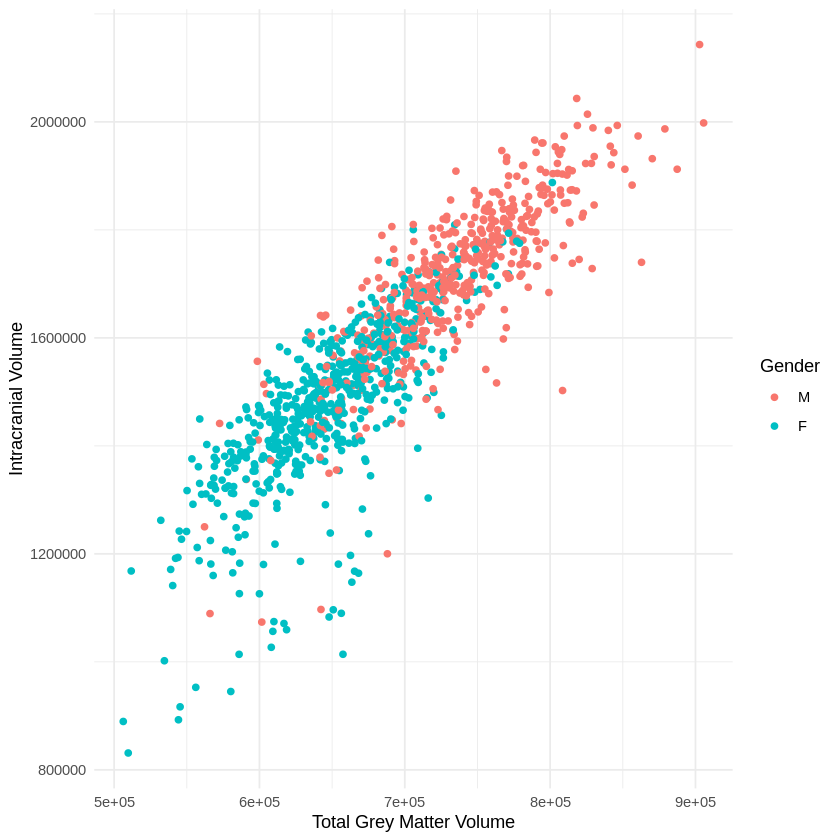

In [22]:
# WRITE YOUR CODE HERE
d1$Gender <- as.factor(d1$Gender)
d1$Gender <- relevel(d1$Gender, ref = "M")

ggplot(d1, aes(x = FS_Total_GM_Vol, y = FS_IntraCranial_Vol, color = Gender)) +
  geom_point() +
  labs(x = "Total Grey Matter Volume",
       y = "Intracranial Volume") +
  theme_minimal()


What patterns do you observe in the scatter plot?

> *Write your response here*
> There is a positive correlation betwen grey matter volume and intracranial volume - as total grey matter volume increases, intracranial volume also increase. But there also appears to be clear clustering of data as well such that male participants appear to have both higher total grey matter volume and intracranial volume.

---
## 2. Logistic classifier (2 points)

We want to try predicting gender using the neural data you have loaded.

(a) Run a logisic regression model to predict gender from total white matter volume, total grey matter volume, and intracranial volume.

In [23]:
# WRITE YOUR CODE HERE
log_model <- glm(Gender ~ FS_Tot_WM_Vol + FS_Total_GM_Vol + FS_IntraCranial_Vol,
                 data = d1, family = binomial)
summary(log_model)


Call:
glm(formula = Gender ~ FS_Tot_WM_Vol + FS_Total_GM_Vol + FS_IntraCranial_Vol, 
    family = binomial, data = d1)

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          2.262e+01  1.347e+00  16.787  < 2e-16 ***
FS_Tot_WM_Vol       -2.140e-06  3.059e-06  -0.699    0.484    
FS_Total_GM_Vol     -1.959e-05  3.145e-06  -6.229 4.70e-10 ***
FS_IntraCranial_Vol -5.020e-06  1.177e-06  -4.263 2.01e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1534.13  on 1112  degrees of freedom
Residual deviance:  919.85  on 1109  degrees of freedom
AIC: 927.85

Number of Fisher Scoring iterations: 5


Which factors are significantly associated with gender?

> FS_Total_GM_Vol and FS_IntraCranial_Vol

(b) Estimate the prediction accuracy of your model (Note: this is the training set accuracy). Set your prediction threshold to 0.5.

In [24]:
# WRITE YOUR CODE HERE
# Use predict() to generate predicted probabilities
d1$predicted_probability <- predict(log_model, type = "response")

# Set threshold to 0.5 to determine predicted Gender values
d1$predicted <- ifelse(d1$predicted_probability >= 0.5, "F", "M")

# Now let's look at the prediction accuracy
confusion_df = data.frame(d1$predicted, d1$Gender)
colnames(confusion_df) = c('predicted', 'actual')

table(confusion_df)
print(paste("Accuracy:",mean(confusion_df$predicted == confusion_df$actual)))


         actual
predicted   M   F
        F 110 516
        M 397  90

[1] "Accuracy: 0.820305480682839"


What is the prediction accuracy for gender from the full model?

> Accuracy: 0.820305480682839

---
## 3. Bootstrapped accuracy (3 points)

Use bootstrapping to estimate the confidence intervals of the _prediction accuracy_ of your model (i.e., the confidence of the correlation between $\hat{y}$ and $y$). Plot the histogram of the bootstrapped prediction accuracies and estimate the confidence intervals off of the standard deviation from the bootstrap.


[1] 0.8203055

ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = d1, statistic = boot.fn, R = 1000)


Bootstrap Statistics :
     original        bias    std. error
t1* 0.8203055 -0.0001662174  0.01222946


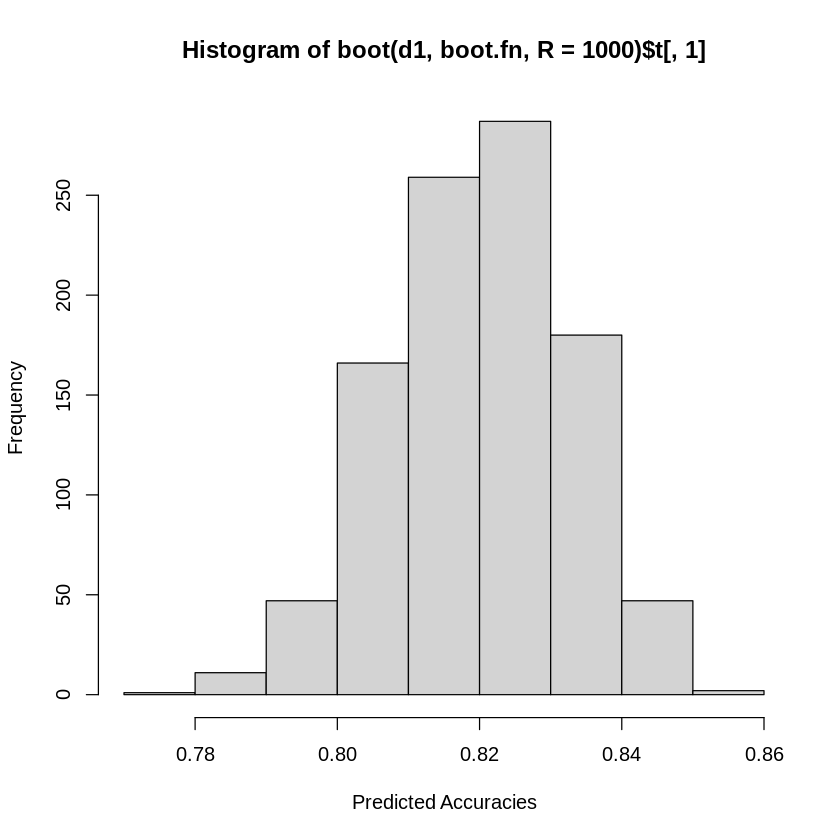

In [35]:
# WRITE YOUR CODE HERE
library(boot)
# boot function - take logistic regression model, predict probs, classify
# then return accuracy
boot.fn <- function(data, index) {
  # Fit the model on the given subset of data
  model <- glm(Gender ~ FS_Tot_WM_Vol + FS_Total_GM_Vol + FS_IntraCranial_Vol,
               data = data, subset = index, family = binomial)

  # Predict probabilities on the given subset of data
  predicted_probs <- predict(model, data[index, ], type = "response")

  # Determine predicted Gender using threshold of 0.5
  predicted_gender <- ifelse(predicted_probs >= 0.5, "F", "M")

  # Calculate prediction accuracy
  accuracy <- mean(predicted_gender == data$Gender[index])

  return(accuracy)
}

# check function output
print(boot.fn(d1, 1:1113))

boot_obj = boot(d1, boot.fn, R=1000) #R=repetitions
print(boot_obj)

hist(boot(d1,boot.fn ,R=1000)$t[,1], xlab="Predicted Accuracies")

How robust is the prediction accuracy of the full model?

> Given the spread of the histogram, the prediction accuracy of the full model seems quite robust.
>

---
## 4. Permutation test for grey matter effects (3 points)

Now run a permutation test, with 1000 iterations, to evaluate how much grey matter volume contributes to the prediction accuracy. Compare the prediction accuracy of the full (unpermuted model) with the distribution of accuracies you get with a randomized grey matter volume term using a histogram (Hint: use the `abline` function to show the original accuracy on the histogram).

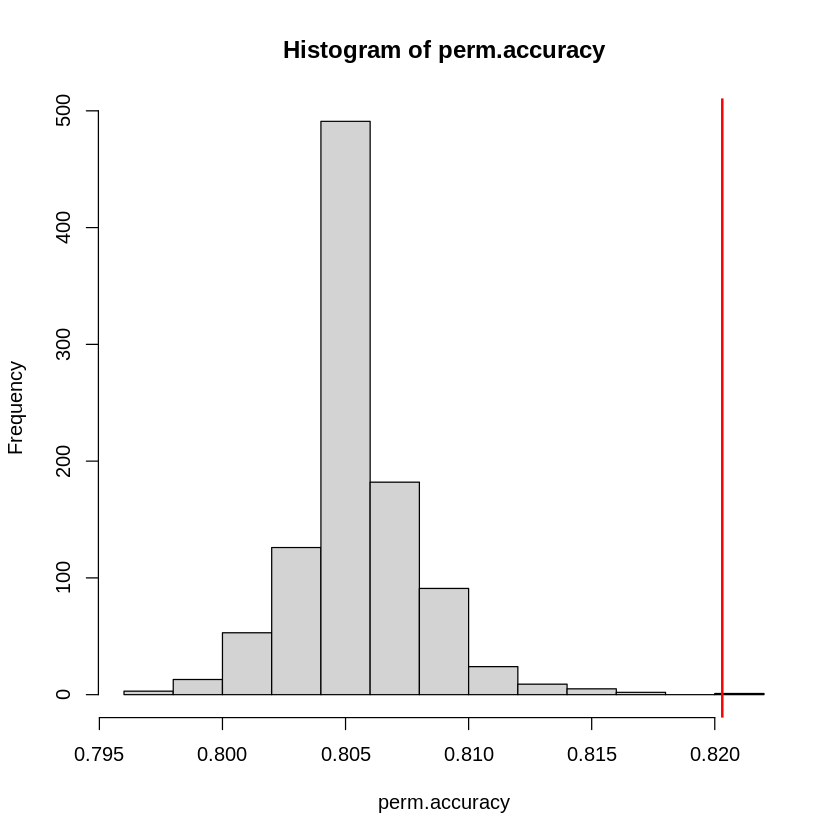

In [39]:
# WRITE YOUR CODE HERE
original_accuracy <- boot.fn(d1, 1:nrow(d1))


# First let's make a copy of the data set that we'll keep permuting
perm_d1 = d1 #want to preserve the non-permuted, true form of data!

# Set the number of iterations
R=1000

# Next make an output object to store the results
perm.accuracy=matrix(NA,nrow=R, ncol=2) #filling with nas at first

# Now just write a for loop where we scramble the observations
# in X using the sample() function. We'll scramble the observations in R different ways
for (i in 1:R){
    perm_d1$FS_Total_GM_Vol <- sample(perm_d1$FS_Total_GM_Vol)
    perm.accuracy[i] <- boot.fn(perm_d1, 1:nrow(perm_d1))
}

# Take a look at the null distributions
hist(perm.accuracy)
abline(v = original_accuracy, col = "red", lwd = 2)

How much does the grey matter volume influence the prediction accuracy of the model?

> the abline indicates that the original model's predicted accuracy is significantly on the edge of the distribution of permuted accuracies. This suggests that the original model's predicted accuracy is significantly higher than what we would expected with the accuracy null distribution (expectation of accuracy if grey matter volume had no real association with gender). Given this, grey matter volume seems to contribute significantly to the prediction accuracy of the model, as if grey matter volume did not influence accuracy, we would expect the abline to fall within the distribution of the null.

---
## 5. Reflection (1 point)

Differentiate the bootstrap from a permutation test. Describe each and when is it appropriate to each.

> The critical difference is whether resampling involves replacement or not - boostrapping involving sampling with replacement while permutation test does not. Bootstrapping answers the question 'what is the range of values I can expect for a statistic, given the varaibility in my data?', while permutation test answers the question 'what kind of pattern would you expect to see if there were no statistical relationship between two (or more) variables?'
> In this exercise, bootstrapping was used to estimate the robustness of model's predicted accuracy while permutation test was used to asssess the significance of gery matter volume's contribution in predicted Gender.

**DUE:** 5pm EST, March 27, 2024

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here.
> *Someone's Name*